### Objective: 


Imagine 63 year old Sara just started feeling a slight headache and a rise in temperature. She feels suddenly unwell with her symptoms and wants to assess what is wrong with her. All Sara knows at the moment is she might be coming up with malaria or the current outbreak of COVID 19. Sara starts to note down her symptoms and wants to enter her symptoms into an algorithm that takes her symptoms and any other necessary variables and predicts the closest disease she might have (Malaria or COVID-19).


Your task is to design a machine learning tool to solve Sara's problem. Your tool should take the symptoms of 63 year old Sara and any other necessary variables your algorithm needs and output the diseases Sara is most likely to have starting with the closest first and descending in that order till the least illness Sara is most likely to have.

### Task 

- Extract disease dataset from kaggle and train a multi classification model. 

#### Result 


- Should be a list of disease and their probabilities 


In [1]:
import pandas as pd
import numpy as np



import  disease  dataset downloaded from kaggle and Aniruddha-Tapas github 

In [2]:
train = pd.read_csv('https://raw.githubusercontent.com/Aniruddha-Tapas/Predicting-Diseases-From-Symptoms/master/Manual-Data/Training.csv')
test = pd.read_csv('https://raw.githubusercontent.com/Aniruddha-Tapas/Predicting-Diseases-From-Symptoms/master/Manual-Data/Testing.csv')


covid_df = pd.read_csv('large_data.csv')


Find similar columns between covid and the rest, and merge them together

In [3]:
l_df = pd.read_csv('large_data.csv')


In [4]:
l_df.columns = l_df.columns.str.lower()
l_df.columns

Index(['cough', 'muscle_aches', 'tiredness', 'sore_throat', 'runny_nose',
       'stuffy_nose', 'fever', 'nausea', 'vomiting', 'diarrhea',
       'shortness_of_breath', 'difficulty_breathing', 'loss_of_taste',
       'loss_of_smell', 'itchy_nose', 'itchy_eyes', 'itchy_mouth',
       'itchy_inner_ear', 'sneezing', 'pink_eye', 'type'],
      dtype='object')

In [5]:
#check for unique values
l_df['label'].unique()

KeyError: 'label'

In [6]:
#rename disease type to label
train = train.rename(columns={'prognosis': 'label'})

train['label'] = train['label'].str.lower()

In [7]:
#rename similar columns 

l_df = l_df.rename(columns={'type': 'label',
 'tiredness':'fatigue', 'fever':'high_fever', 'shortness_of_breath':'breathlessness', 
 'sneezing':'continuous_sneezing','pink_eye':'redness_of_eyes'})


l_df['label'] = l_df['label'].str.lower()

In [8]:
#merge both dataset
df = pd.concat([l_df, train], ignore_index=False)

In [9]:
#fill missing values with 0 since 0 mean they dont feel any of the symptom 
df = df.fillna(0)

In [10]:
#assign dependent and independent values

X = df.drop('label', axis =1)
y = df['label']

### Feature Selection 


using multiple method and count the selected times for each feature

In [22]:


from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=60), max_features=len(X.columns))
embeded_rf_selector.fit(X, y)

embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()
print(str(len(embeded_rf_feature)), 'selected features')

20 selected features


In [23]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
X_norm = MinMaxScaler().fit_transform(X)




from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression

embeded_lr_selector = SelectFromModel(LogisticRegression(penalty="none"), max_features=len(X.columns))
embeded_lr_selector.fit(X_norm, y)

embeded_lr_support = embeded_lr_selector.get_support()
embeded_lr_feature = X.loc[:,embeded_lr_support].columns.tolist()
print(str(len(embeded_lr_feature)), 'selected features')

42 selected features
/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [13]:
!pip install lightgbm==3.3.1

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [24]:
from sklearn.feature_selection import SelectFromModel
from lightgbm import LGBMClassifier

lgbc=LGBMClassifier(n_estimators=500, learning_rate=0.01, num_leaves=32, colsample_bytree=0.2,
            reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)

embeded_lgb_selector = SelectFromModel(lgbc, max_features=len(X.columns))
embeded_lgb_selector.fit(X, y)

embeded_lgb_support = embeded_lgb_selector.get_support()
embeded_lgb_feature = X.loc[:,embeded_lgb_support].columns.tolist()
print(str(len(embeded_lgb_feature)), 'selected features')

29 selected features


In [25]:
feature_selection_df = pd.DataFrame({'Feature':list(X.columns),'Logistics':embeded_lr_support,
                                    'Random Forest':embeded_rf_support, 'LightGBM':embeded_lgb_support})
# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# display the top 100
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)
sel_fe = feature_selection_df.loc[feature_selection_df['Total'] == 3]
sel_df_col= list(sel_fe['Feature'])

##### Best Features

#### reassign x and y values

In [27]:
X = df[sel_df_col]
y = df['label']

split dataset

In [28]:


from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)

## Build Models

Random forest

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [30]:


rfc = RandomForestClassifier()
rfc.fit(x_train, y_train)
result = rfc.predict(x_test)
#print(classification_report(y_true=y_test.values, y_pred=result))

from sklearn import metrics
from sklearn.metrics import accuracy_score


result_train = rfc.predict(x_train)

print('Train accuracy = {}'.format(
        accuracy_score(result_train , y_train) * 100)
     )


result_test = rfc.predict(x_test)

print('Test accuracy = {}'.format(
        accuracy_score(result_test, y_test) * 100)
     )
f1_score = metrics.f1_score(result_train, y_train, average='weighted')
print(' F1 Train classification score: {}'.format(f1_score* 100))


f1_score = metrics.f1_score(result_test, y_test, average='weighted')
print(' F1 Test classification score: {}'.format(f1_score* 100))

Train accuracy = 89.49060711934781
Test accuracy = 86.73417721518987
 F1 Train classification score: 91.15137552563422
 F1 Test classification score: 88.52693973023659


RepeatedStratifiedKFold

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

from numpy import mean
from numpy import std
# evaluate the model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=4, random_state=32)
n_scores = cross_val_score(rfc,x_train, y_train,  cv=10, n_jobs=-1, error_score='raise')
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Accuracy: 0.849 (0.004)


Feature importance

Check for the features with great impact to the model

In [31]:
rfcim = rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc.estimators_], axis=0)

Current size: [6.0, 4.0]


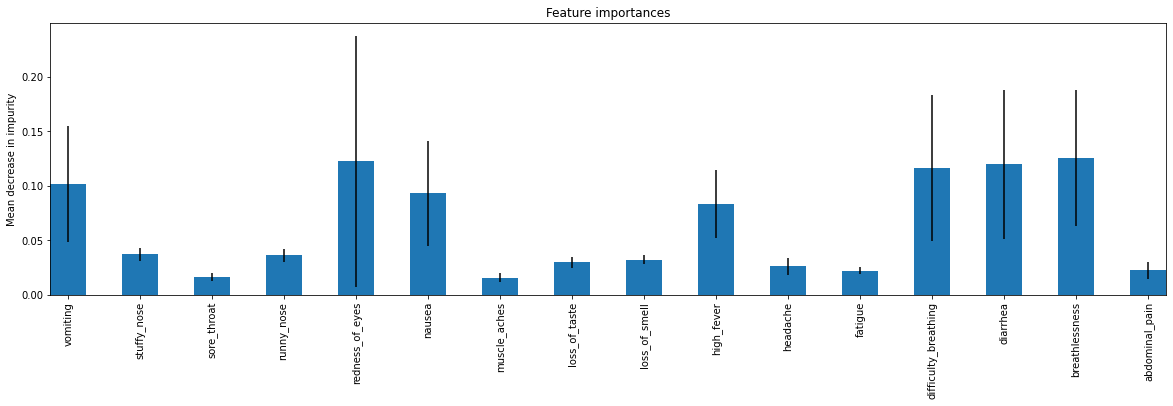

In [32]:

forest_importances = pd.Series(rfcim, index=list(X.columns))
fig_size = plt.rcParams["figure.figsize"] #Get current size
print("Current size:", fig_size)
fig_size[1] = 5
fig_size[0] =20
plt.rcParams["figure.figsize"] = fig_size

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
plt.autoscale(enable=True, axis='x', tight=True)#plt.axis('tight')

plt.show()


In [33]:
#retrain with the important features

retrain_features = forest_importances.loc[forest_importances >0.050]

In [34]:
retrain_features_col = list(retrain_features.index)


label = 'label'
retrain_features_col.append(label)


In [35]:
retrain_features_col

['vomiting',
 'redness_of_eyes',
 'nausea',
 'high_fever',
 'difficulty_breathing',
 'diarrhea',
 'breathlessness',
 'label']

In [36]:
retrain_df = df[retrain_features_col]

In [37]:
retrain_df.loc[retrain_df['label'] =='malaria']

,vomiting,redness_of_eyes,nausea,high_fever,difficulty_breathing,diarrhea,breathlessness,label
150,1,0,1,1,0.0,0.0,0,malaria
151,1,0,1,1,0.0,0.0,0,malaria
152,1,0,1,1,0.0,0.0,0,malaria
153,1,0,1,1,0.0,0.0,0,malaria
154,0,0,1,1,0.0,0.0,0,malaria
...,...,...,...,...,...,...,...,...
4730,1,0,1,1,0.0,0.0,0,malaria
4771,1,0,1,1,0.0,0.0,0,malaria
4812,1,0,1,1,0.0,0.0,0,malaria
4853,1,0,1,1,0.0,0.0,0,malaria


In [38]:
X_rt = retrain_df.drop('label',axis = 1)
y_rt = retrain_df['label']

In [39]:

from sklearn.model_selection import train_test_split
x_train_rt, x_test_rt, y_train_rt, y_test_rt = train_test_split(X_rt, y_rt, test_size=0.2, random_state=32)



rfc_rt = RandomForestClassifier()
rfc_rt.fit(x_train_rt, y_train_rt)



RandomForestClassifier()

In [40]:
from sklearn import metrics
from sklearn.metrics import accuracy_score


result_rt_train = rfc_rt.predict(x_train_rt)

print('Train accuracy = {}'.format(
        accuracy_score(result_rt_train , y_train_rt) * 100)
     )


result_rt_test = rfc_rt.predict(x_test_rt)

print('Test accuracy = {}'.format(
        accuracy_score(result_rt_test, y_test_rt) * 100)
     )


Train accuracy = 84.31312977872297
Test accuracy = 84.78987341772152


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samplesx_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

sgd classifier

In [41]:


from sklearn.linear_model import SGDClassifier
sgdc = SGDClassifier(loss="hinge", penalty="l1", max_iter=10)
sgdc.fit(x_train, y_train)

/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,


SGDClassifier(max_iter=10, penalty='l1')

In [43]:
sgd_train = sgdc.predict(x_train)

print('Train accuracy = {}'.format(
        accuracy_score(sgd_train , y_train) * 100)
     )
f1_score = metrics.f1_score(sgd_train, y_train, average='weighted')
print(' F1 Train classification score: {}'.format(f1_score* 100))

sgd_test= sgdc.predict(x_test)

print('Test accuracy = {}'.format(
        accuracy_score(sgd_test, y_test) * 100)
     )
f1_score = metrics.f1_score(sgd_test, y_test, average='weighted')
print(' F1 Test classification score: {}'.format(f1_score* 100))

Train accuracy = 88.2601650716492
 F1 Train classification score: 92.0246144175505
Test accuracy = 88.21265822784811
 F1 Test classification score: 91.84853279855922


Gradient Boosting classifier

In [47]:
from sklearn.datasets import make_hastie_10_2
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1,
 max_depth=1, random_state=32).fit(x_train, y_train)


0.884930882576333

In [50]:
clf_train = clf.predict(x_train)

print('Train accuracy = {}'.format(
        accuracy_score(clf_train , y_train) * 100)
     )
f1_score = metrics.f1_score(clf_train, y_train, average='weighted')
print(' F1 Train classification score: {}'.format(f1_score* 100))

clf_test= clf.predict(x_test)

print('Test accuracy = {}'.format(
        accuracy_score(clf_test, y_test) * 100)
     )
f1_score = metrics.f1_score(clf_test, y_test, average='weighted')
print(' F1 Test classification score: {}'.format(f1_score* 100))

Train accuracy = 88.4930882576333
 F1 Train classification score: 92.66631800991091
Test accuracy = 88.41518987341772
 F1 Test classification score: 92.52590498327555


Decision Tree Classifier

In [49]:

from sklearn.tree import DecisionTreeClassifier
clfd = DecisionTreeClassifier(random_state=32)
clfd.fit(x_train, y_train)


0.8949060711934782

In [52]:
clfd_train = clfd.predict(x_train)

print('Train accuracy = {}'.format(
        accuracy_score(clfd_train , y_train) * 100)
     )
f1_score = metrics.f1_score(clfd_train, y_train, average='weighted')
print(' F1 Train classification score: {}'.format(f1_score* 100))

clfd_test= clfd.predict(x_test)

print('Test accuracy = {}'.format(
        accuracy_score(clfd_test, y_test) * 100)
     )
f1_score = metrics.f1_score(clfd_test, y_test, average='weighted')
print(' F1 Test classification score: {}'.format(f1_score* 100))

Train accuracy = 89.49060711934781
 F1 Train classification score: 90.8626548825053
Test accuracy = 86.8253164556962
 F1 Test classification score: 88.20589566889909


### Export model

In [53]:

import pickle
from joblib import dump, load 
 

dump(clf, "gbmodel.joblib.dat")

['gbmodel.joblib.dat']

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=1b0770af-dab9-475b-b419-2a7c23121b4f' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>